In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from nltk.stem.lancaster import LancasterStemmer
import community
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pylab as pl
from scipy import sparse
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from tools.data_cleansing import clean
from tools.data_exploration import print_email_by_id, emails_sent_distribution, emails_received_distribution,\
body_length_distribution, number_of_recipients_distribution
from tools.data_handling import enrich_emails, load_email_senders, unique_recipients, address_book, load_emails,\
unique_domain_names, name_to_address, mail_body_orig_message
from tools.evaluation import precision
from tools.submission import save_submission
from tools.staff_graph import construct_graph, compute_teams, assign_team, compute_summary_graph

# Loading data

In [2]:
df_emails = enrich_emails()

Reading dataframe from data/enrich_emails.csv


In [3]:
df_emails.head()

,date,body,recipients,sender
mid,,,,
60,2000-07-25 08:14:00,Legal has been assessing the risks of doing bl...,robert.badeer@enron.com murray.o neil@enron.co...,christian.yoder@enron.com
66,2000-08-03 02:56:00,Attached is a spreadsheet to estimate export f...,kim.ward@enron.com robert.badeer@enron.com mur...,heather.dunton@enron.com
74,2000-08-15 05:37:00,Kevin/Bob: Here is a quick rundown on the cons...,robert.badeer@enron.com john.massey@enron.com ...,janel.guerrero@enron.com
80,2000-08-20 14:12:00,check this out and let everyone know what s up...,robert.badeer@enron.com jeff.richter@enron.com,tim.belden@enron.com
83,2000-08-22 08:17:00,Further to your letter to us (addressed to Mr....,pgillman@schiffhardin.com kamarlantes@calpx.co...,christian.yoder@enron.com


# Initialize graph

In [4]:
G_connected = construct_graph(df_emails)

In [5]:
print(nx.is_connected(G_connected))

True


In [6]:
G_connected.number_of_nodes()

9781

# Constructing a smaller graph

In [7]:
for node in G_connected.nodes():
    if G_connected.degree(node)<=3 and G_connected.degree(node,weight='weight')<=3.1:
        G_connected.remove_node(node)

### Computing teams

In [8]:
G_connected.number_of_nodes()

1570

In [9]:
nx.is_connected(G_connected)

True

In [10]:
output_dict = compute_teams(G_connected)

/Users/Mazz/Documents/MVA/S2-ALTEGRAD/email-classification-challenge/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/Mazz/Documents/MVA/S2-ALTEGRAD/email-classification-challenge/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/Mazz/Documents/MVA/S2-ALTEGRAD/email-classification-challenge/venv/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/Mazz/Do

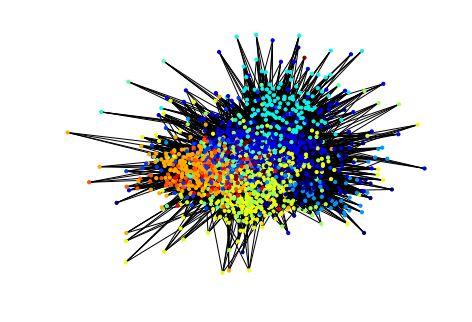

In [11]:
n_clusters = output_dict["n_clusters"]
teams = output_dict["teams"]
parts = output_dict["parts"]
list_teams = [teams[node] for node in G_connected.nodes()]

nx.draw_spring(G_connected, cmap = plt.get_cmap('jet'), node_color = list_teams, node_size=10, with_labels=False)

In [12]:
n_clusters

12

# Summary of the smaller graph

#### Constructing a graph with one node per cluster

In [25]:
G_community = compute_summary_graph(G_connected, n_clusters, parts)

#### Sparsifying Graph

In [26]:
for a, b in G_community.edges():
    if G_community[a][b]['weight'] < 20:
        G_community.remove_edge(a, b)
    if int(a)==int(b) and G_community.has_edge(a,b):
        G_community.remove_edge(a, b)
print(G_community.edges(data='weight'))

[(288, 39, 27.99036985360376), (288, 138, 46.50548096228855), (288, 82, 23.793360845352808), (288, 78, 32.19456929757897), (288, 114, 41.94194095980553), (288, 53, 25.702786478360913), (288, 55, 26.7656460927493), (288, 286, 31.735658090321312), (288, 223, 86.86923947118606), (101, 138, 24.595499065483533), (138, 82, 24.42301587301587), (138, 114, 27.8064286393661), (138, 286, 28.881629318535364), (138, 223, 34.42398462854576), (107, 114, 33.906510541372384), (107, 286, 64.46896260893143), (82, 114, 28.769120917396783), (82, 286, 33.561646939368785), (78, 114, 29.042480145712663), (78, 286, 34.80045763803893), (78, 223, 32.64694702355648), (114, 286, 78.7942476878569), (114, 223, 29.811638166987965), (286, 223, 38.685823913017245)]


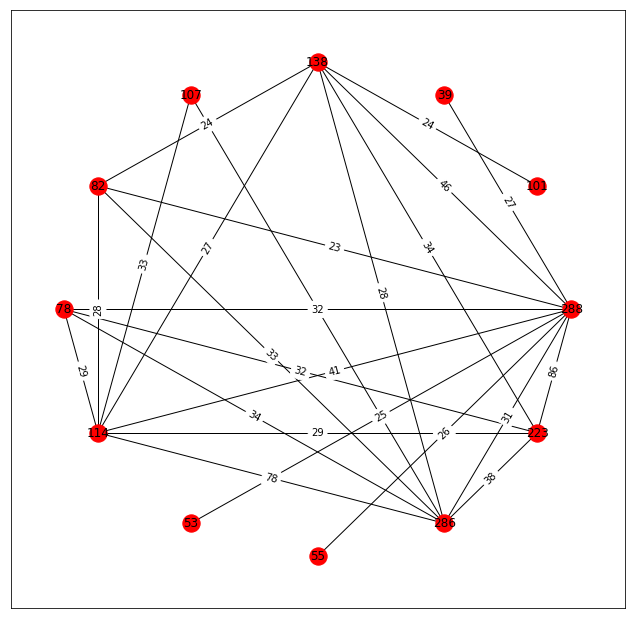

In [27]:
fig=pl.figure(figsize=(11,11))
pos=nx.circular_layout(G_community)
#edges
nx.draw_networkx(G_community,pos,
                edgelist=[e for e in G_community.edges()])


labels = nx.get_edge_attributes(G_community,'weight')
for e in G_community.edges():
    labels[e] = int(labels[e])
#flow label
nx.draw_networkx_edge_labels(G_community, pos,
                        edge_labels=labels, node_size=100000)

#hide axis
fig.gca().axes.get_xaxis().set_ticks([])
fig.gca().axes.get_yaxis().set_ticks([])

pl.show()

In [23]:
G_connected.size(weight='weight')

2868.95014910745

In [24]:
G_community.size(weight='weight')

1300.2267604329695